<a href="https://colab.research.google.com/github/AstridSerruto/Projects/blob/master/Predicting/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rainfall Prediction is a difficult and uncertain task that has a significant impact on the environment. Timely and accurate forecasting can help reduce human and financial loss. This study presents a set of experiments that involve the use of common machine learning techniques to create models that can predict whether it will rain tomorrow or not based on the weather data for that day in major cities in Australia.

In [82]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

In [87]:
from google.colab import files
uploaded = files.upload()
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

Saving weatherAUS.csv to weatherAUS (5).csv


NameError: ignored

In [ ]:
#Shape and information about the data
full_data.info()

We have 24 columns and 142193 rows in this set.
For convenience we will convert 'Rain Today' and 'Rain Tomorrow' from objects(Yes/No) to binary(1/0).

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

We will check the balance of the data. If the data set is unbalanced, we wil downsample the majority or oversample the minority to balance it.

In [ ]:
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['navy', 'skyblue'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can see that there is a class inbalance. Since the size of the dataset is small, we will use oversampling of the minority class.

In [ ]:
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

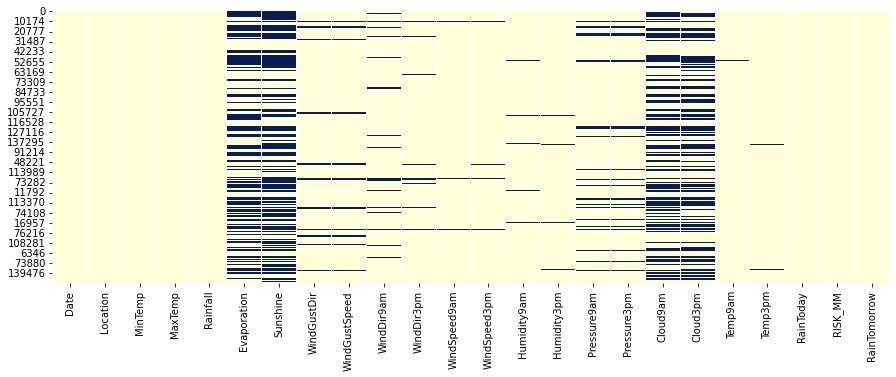

In [55]:
#Checking for missing 
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(oversampled.isnull(), cbar=False, cmap='YlGnBu')

'Evaporation', 'Sunshine', 'Cloud9am' and 'Cloud3pm' have the highest percentage of missing values. We will check these four features.

In [56]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


We observe that the 4 features have less than 50 per cent missing data, we’ll consider them in our model with proper imputation.

We will impute the categorical columns with mode, and then we will use the label encoder to convert them to numeric numbers. Once all the columns in the full data frame are converted to numeric columns, we will impute the missing values ​​using the Multiple Imputation by Chained Equations (MICE) package. 

In [57]:
#Identify the categorical features
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [88]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [89]:
#Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [90]:
#Multiple Imputation by Chained Eauations
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

The dataset has no 'NaN' values.
We will detect outliers using the interquartile range and remove them to get the final working dataset. 

In [91]:
#Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [92]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

We are now going to check multicollinearity.

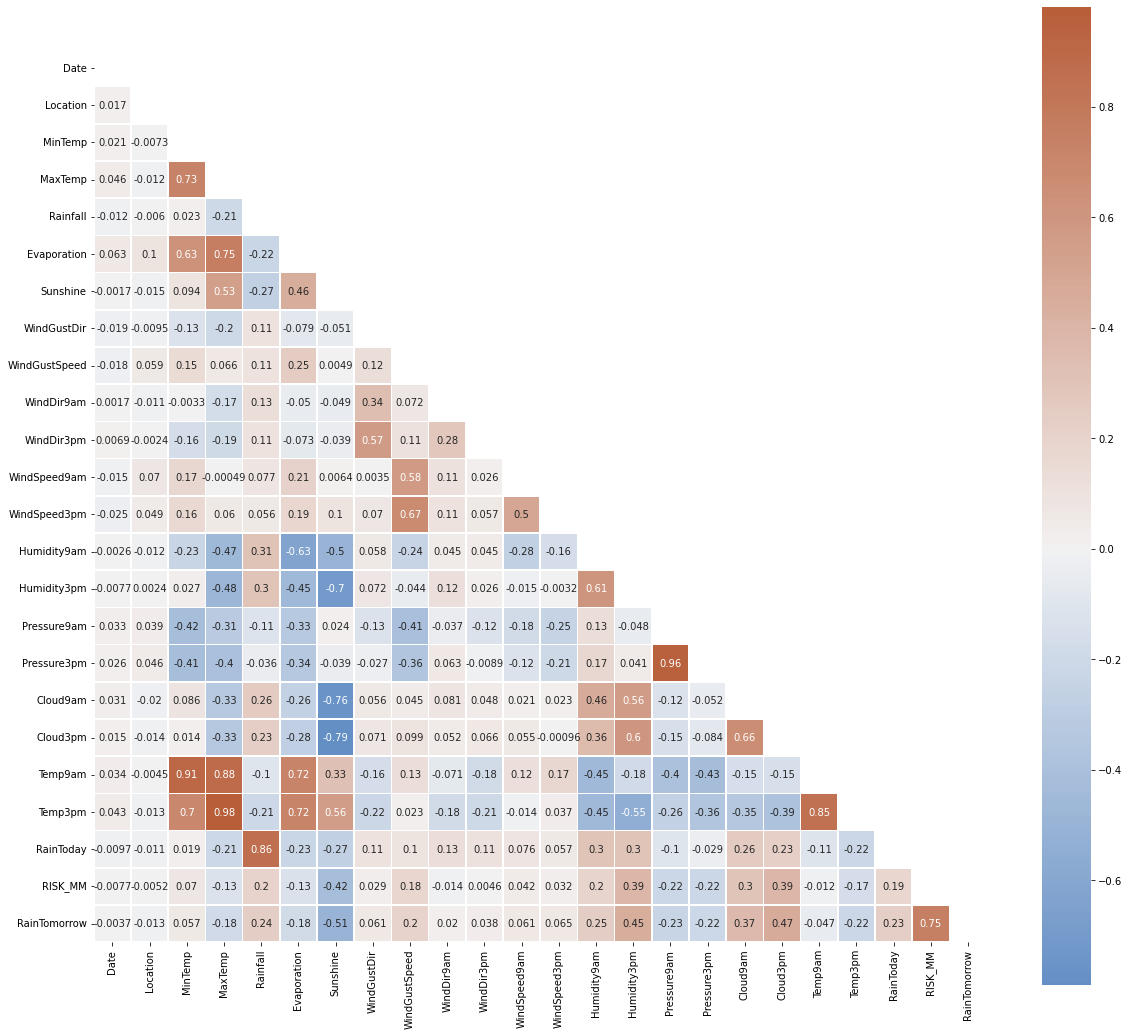

In [94]:
#Correlation Heatmap

corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

The following feature pairs have a strong correlation with each other:

    MaxTemp and MinTemp
    Pressure9h and pressure3h
    Temp9am and Temp3pm
    Evaporation and MaxTemp
    MaxTemp and Temp3pm 

But in no case is the correlation value equal to a perfect “1”. We are therefore not removing any functionality.


Feature Selection for Rainfall Prediction

I will use both the filter method and the wrapper method for feature selection to train our rainfall prediction model.

Selecting features by filtering method (chi-square value): before doing this, we must first normalize our data. We use MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [96]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [97]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [98]:
#Select features with the wrapping method(random forest)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


We will divide the dataset into training (75%) and test (25%) sets respectively to train the rainfall prediction model. For best results, we will standardize our X_train and X_test data:

In [100]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [101]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [102]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.78963609007217
ROC Area under Curve = 0.76976981489154
Cohen's Kappa = 0.5494516226632338
Time taken = 3.6503469944000244
              precision    recall  f1-score   support

         0.0    0.80822   0.85949   0.83307     23948
         1.0    0.75520   0.68005   0.71566     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76977   0.77436     39213
weighted avg    0.78758   0.78964   0.78736     39213



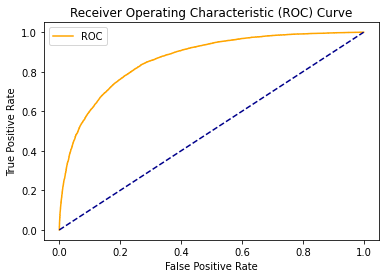

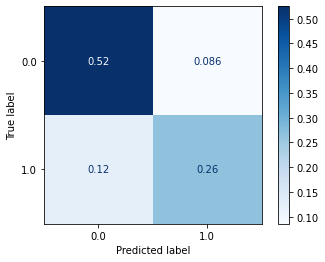

In [103]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.8677734424808099
ROC Area under Curve = 0.8647977485447097
Cohen's Kappa = 0.7240321535188811
Time taken = 0.5112509727478027
              precision    recall  f1-score   support

         0.0    0.90262   0.87824   0.89026     23948
         1.0    0.81674   0.85136   0.83369     15265

    accuracy                        0.86777     39213
   macro avg    0.85968   0.86480   0.86198     39213
weighted avg    0.86919   0.86777   0.86824     39213



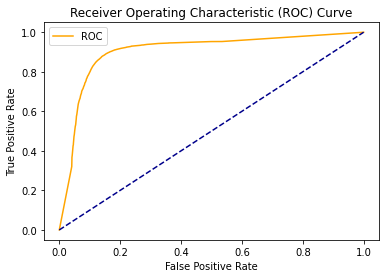

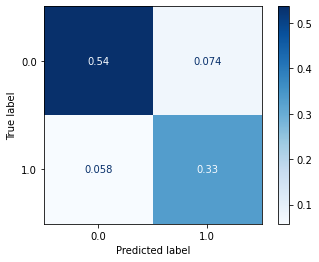

In [104]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Accuracy = 0.8902404814729808
ROC Area under Curve = 0.885103820588237
Cohen's Kappa = 0.7694035401812199
Time taken = 348.5510423183441
              precision    recall  f1-score   support

         0.0    0.91165   0.90830   0.90997     23948
         1.0    0.85697   0.86191   0.85943     15265

    accuracy                        0.89024     39213
   macro avg    0.88431   0.88510   0.88470     39213
weighted avg    0.89036   0.89024   0.89030     39213



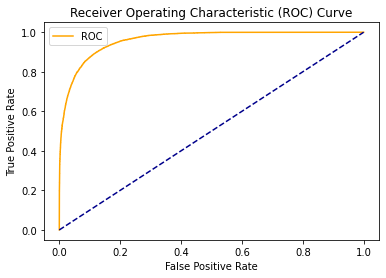

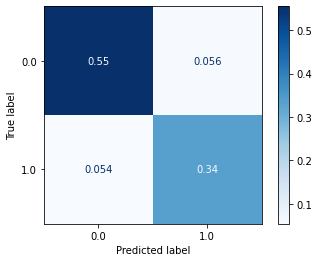

In [105]:
# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

Accuracy = 0.9280595720806876
ROC Area under Curve = 0.9265770863620824
Cohen's Kappa = 0.8493714659078331
Time taken = 31.407170295715332
              precision    recall  f1-score   support

         0.0    0.94812   0.93327   0.94064     23948
         1.0    0.89783   0.91988   0.90872     15265

    accuracy                        0.92806     39213
   macro avg    0.92297   0.92658   0.92468     39213
weighted avg    0.92854   0.92806   0.92821     39213



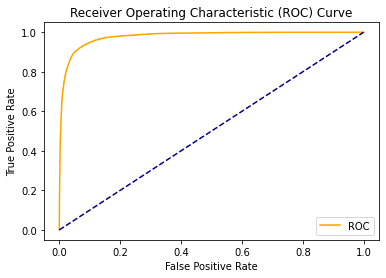

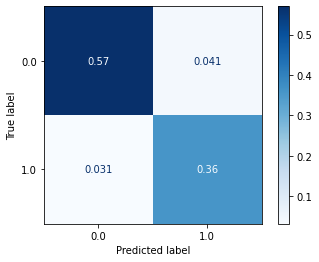

In [106]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

Accuracy = 0.9557544691811389
ROC Area under Curve = 0.9558424476419074
Cohen's Kappa = 0.9073851935381758
Time taken = 385.94819617271423
              precision    recall  f1-score   support

         0.0    0.97163   0.95545   0.96347     23948
         1.0    0.93188   0.95624   0.94390     15265

    accuracy                        0.95575     39213
   macro avg    0.95176   0.95584   0.95369     39213
weighted avg    0.95616   0.95575   0.95585     39213



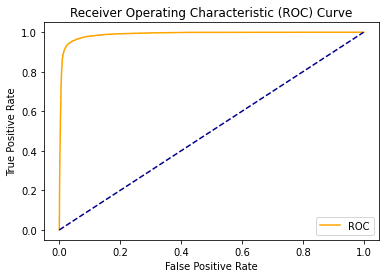

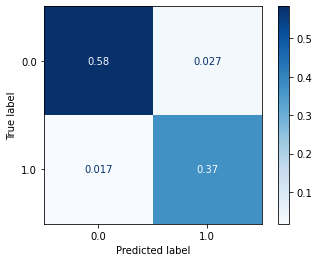

In [107]:
# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

Plotting Decision Region for all Models

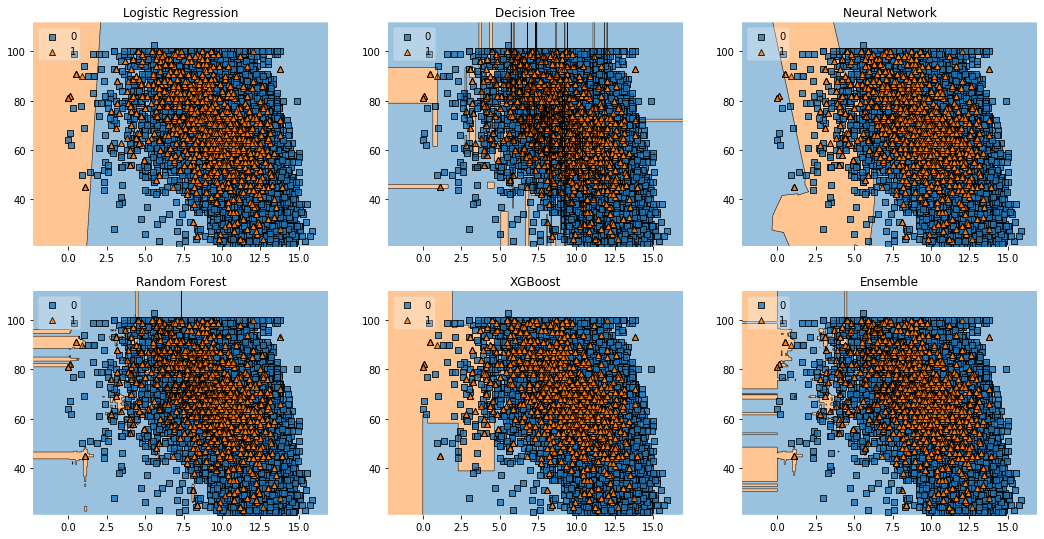

In [111]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf7], weights=[1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()



XGBoost and Random Forest models have a much lower number of misclassified data points compared to other models.


Rainfall Prediction Model Comparison

Now we need to decide which model performed best based on Precision Score, ROC_AUC, Cohen’s Kappa and Total Run Time. One point to mention here is: we could have considered F1-Score as a better metric for judging model performance instead of accuracy, but we have already converted the unbalanced dataset to a balanced one, so consider accuracy as a metric for deciding the best model is justified in this case.

For a better decision, we chose “Cohen’s Kappa” which is actually an ideal choice as a metric to decide on the best model in case of unbalanced datasets. Let’s check which model worked well on which front:

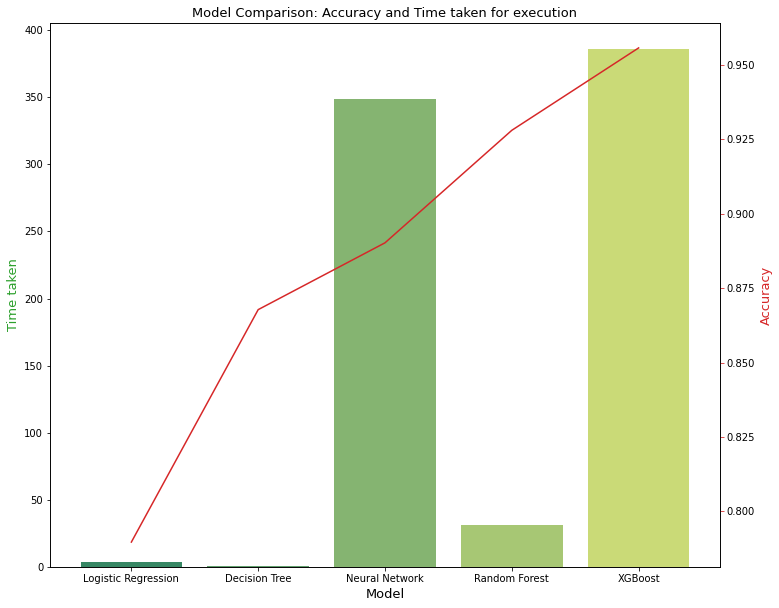

In [112]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf,tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

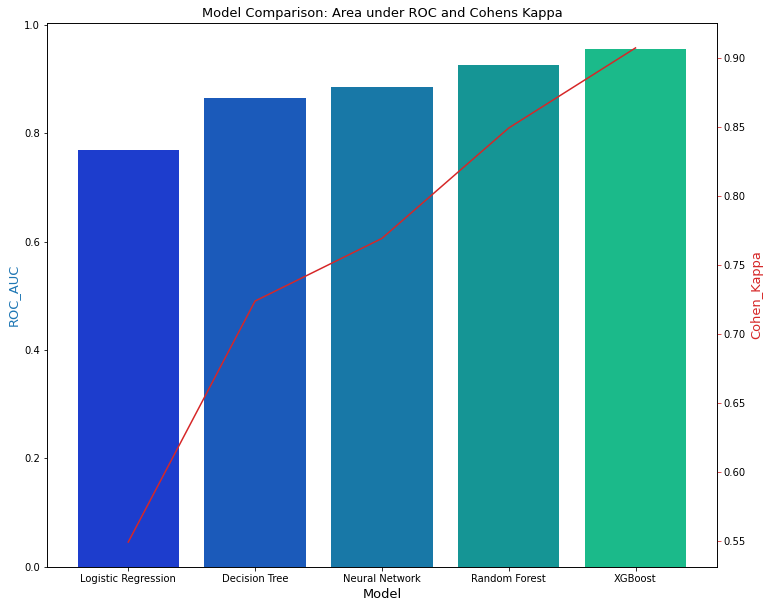

In [113]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

We can see that the most accurate models are XGBoost(95.6%) and Neural Networks(89.0%). However, if speed is an important issue to consider, Random Forest(84.9%) can be used.